In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [36]:
df1 = pd.read_csv("ADANIPORTS.csv")

In [37]:
df = df1
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [4]:
print(df.isnull().sum())

Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Trades                866
Deliverable Volume      0
%Deliverble             0
dtype: int64


In [5]:
df.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [38]:
#Input X with ['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Volume','Turnover'] for better dependencies
X = df[['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Volume',
       'Turnover']].values
y = df['Close'].values

In [39]:
#Pre-process data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

seq_len = 7
X_lstm = []
y_lstm = []

for i in range(seq_len, len(X_scaled)):
    X_lstm.append(X_scaled[i-seq_len:i])
    y_lstm.append(y_scaled[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

In [40]:
#ADANIPORTS split dataset 50-40-10
X_train, X_, y_train, y_ = train_test_split(X_lstm,y_lstm,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (1657, 7, 8) X_cv.shape: (1326, 7, 8) X_test.shape: (332, 7, 8)


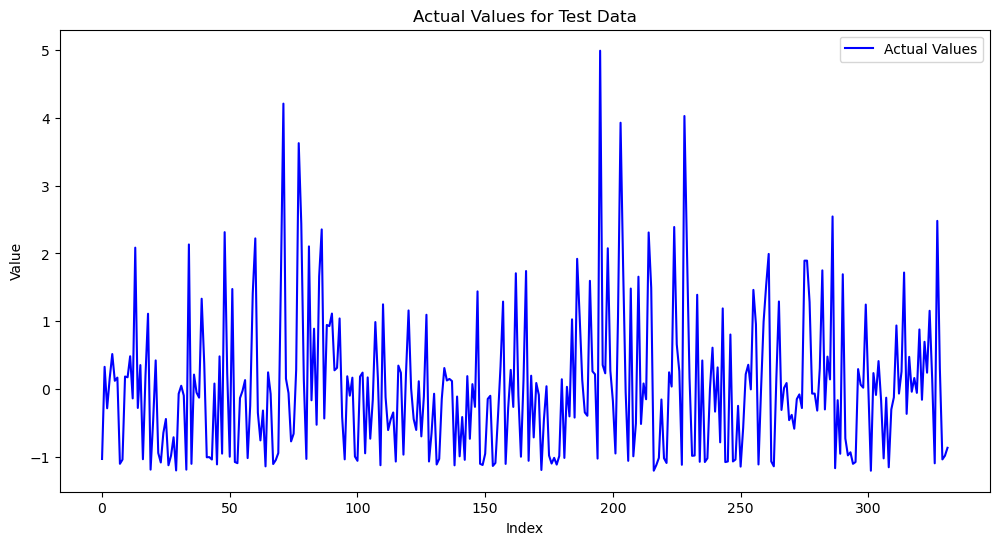

In [41]:
#Data to be tested upon later
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual Values for Test Data')
plt.legend()
plt.show()

In [10]:
#LSTM Model
model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True )

In [11]:
history = model.fit(X_train, y_train, epochs=40, batch_size=34, validation_data=(X_cv, y_cv), callbacks=[early_stopping], verbose=1)

train_mae = mean_absolute_error(y_train, model.predict(X_train))
cv_mae = mean_absolute_error(y_cv, model.predict(X_cv))

print(f"Training MAE: {train_mae:.4f}")
print(f"Cross-Validation MAE: {cv_mae:.4f}")

mae_percentage = ((train_mae - cv_mae) / train_mae) * 100
print(f"MAE Percentage Difference: {mae_percentage:.2f}%")

Epoch 1/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.8780 - val_loss: 0.3921
Epoch 2/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3719 - val_loss: 0.1258
Epoch 3/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1662 - val_loss: 0.0771
Epoch 4/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1163 - val_loss: 0.0528
Epoch 5/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0986 - val_loss: 0.0426
Epoch 6/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0897 - val_loss: 0.0394
Epoch 7/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0933 - val_loss: 0.0365
Epoch 8/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0764 - val_loss: 0.0349
Epoch 9/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0624 - val_loss: 0.0322
Epoch 10/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0594 - val_loss: 0.0310
Epoch 11/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0780 - val_loss: 0.0318
Epoch 12/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0725 - val_l

In [42]:
train_mse = model.evaluate(X_train, y_train, verbose=0)

cv_mse = model.evaluate(X_cv, y_cv, verbose=0)

train_rmse = np.sqrt(train_mse)
cv_rmse = np.sqrt(cv_mse)

print(f"Training MSE: {train_mse:.4f}")
print(f"Cross-Validation MSE: {cv_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Cross-Validation RMSE: {cv_rmse:.4f}")

rmse_percentage = ((train_rmse - cv_rmse) / train_rmse) * 100
print(f"RMSE Percentage Difference: {rmse_percentage:.2f}%")

Training MSE: 0.0183
Cross-Validation MSE: 0.0174
Training RMSE: 0.1354
Cross-Validation RMSE: 0.1318
RMSE Percentage Difference: 2.66%


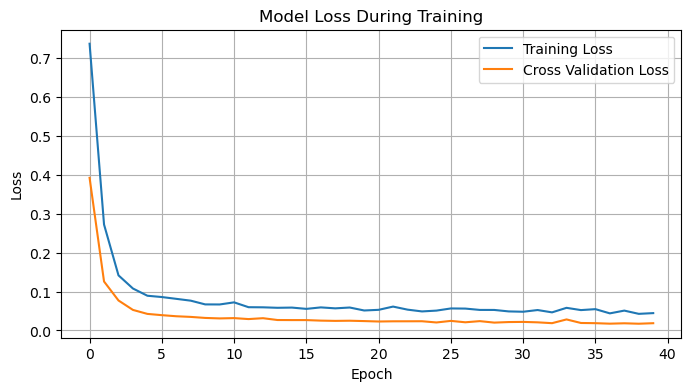

In [43]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Cross Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [45]:
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)

print(f"Training MAE: {train_mae:.4f}")
print(f"Testing MAE: {test_mae:.4f}")

mae_percentage = ((train_mae - test_mae) / train_mae) * 100
print(f"MAE Percentage Difference: {mae_percentage:.2f}%")

Training MAE: 0.0644
Testing MAE: 0.0669
MAE Percentage Difference: -3.84%


In [46]:
#Transform Data back and plot
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
y_train_original = scaler_y.inverse_transform(y_train)
y_test_original = scaler_y.inverse_transform(y_test)

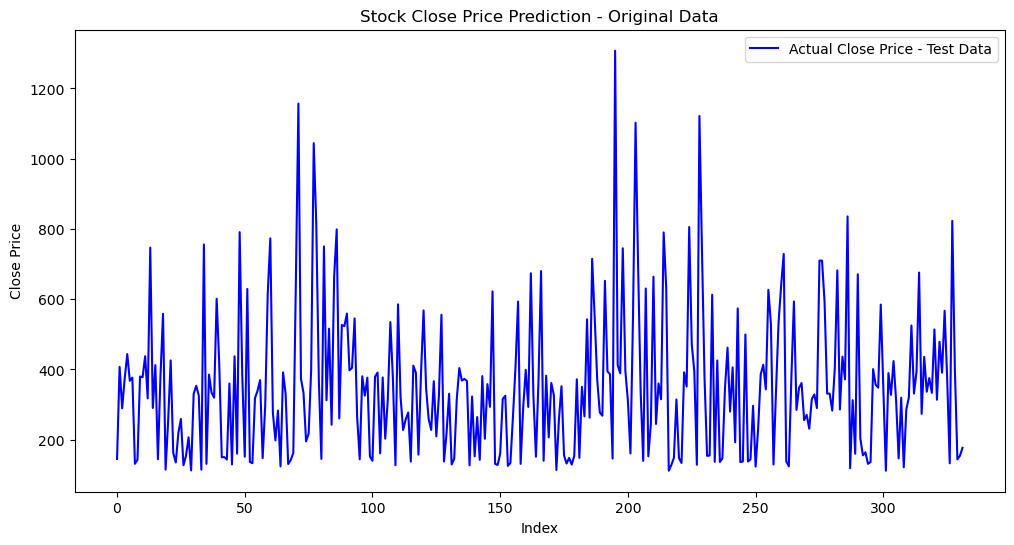

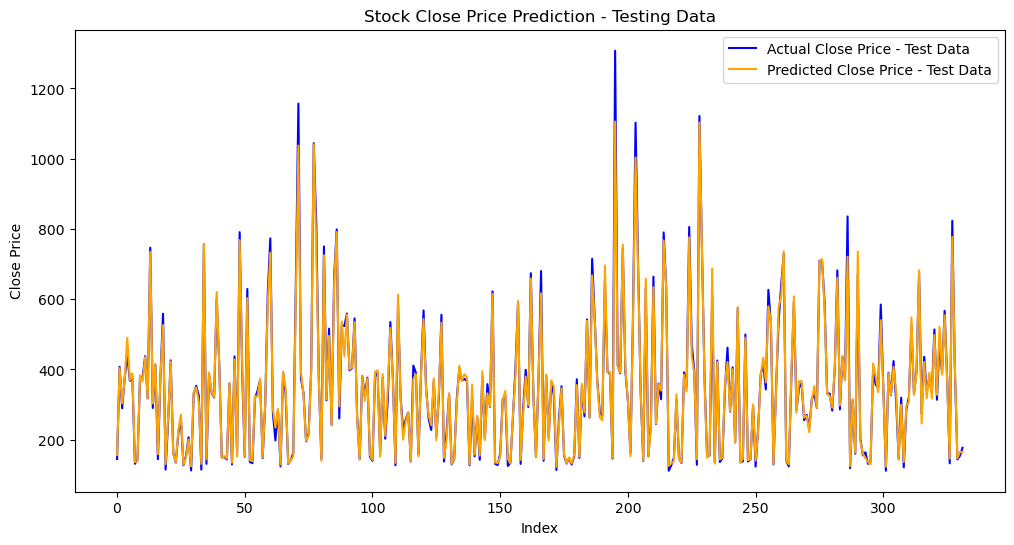

In [47]:
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(range(len(y_test_original)), y_test_original, color='blue', label='Actual Close Price - Test Data')
plt.title('Stock Close Price Prediction - Original Data')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))

# Plot testing data
plt.plot(range(len(y_test_original)), y_test_original, color='blue', label='Actual Close Price - Test Data')
plt.plot(range(len(test_predict)), test_predict, color='orange', label='Predicted Close Price - Test Data')

plt.title('Stock Close Price Prediction - Testing Data')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [48]:
#Dataset_2 - RELIANCE
df2 = pd.read_csv("RELIANCE.csv")
df2.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [49]:
print(df2.isnull().sum())

Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2850
Deliverable Volume     514
%Deliverble            514
dtype: int64


In [50]:
#Input Variables and Pre-process data
X = df2[['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Volume',
       'Turnover']].values
y = df2['Close'].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

seq_len = 7
X_lstm = []
y_lstm = []

for i in range(seq_len, len(X_scaled)):
    X_lstm.append(X_scaled[i-seq_len:i])
    y_lstm.append(y_scaled[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)


In [51]:
#RELIANCE split dataset 50-40-10(Only cause the dataset is too big)
X_train, X_, y_train, y_ = train_test_split(X_lstm,y_lstm,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.2, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (2534, 7, 8) X_cv.shape: (2027, 7, 8) X_test.shape: (507, 7, 8)


In [52]:
#Predict using trained LSTM model
test_predict = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [53]:
test_mae = mean_absolute_error(y_test, test_predict)
print(f"Testing MAE: {test_mae:.4f}")

Testing MAE: 0.0769


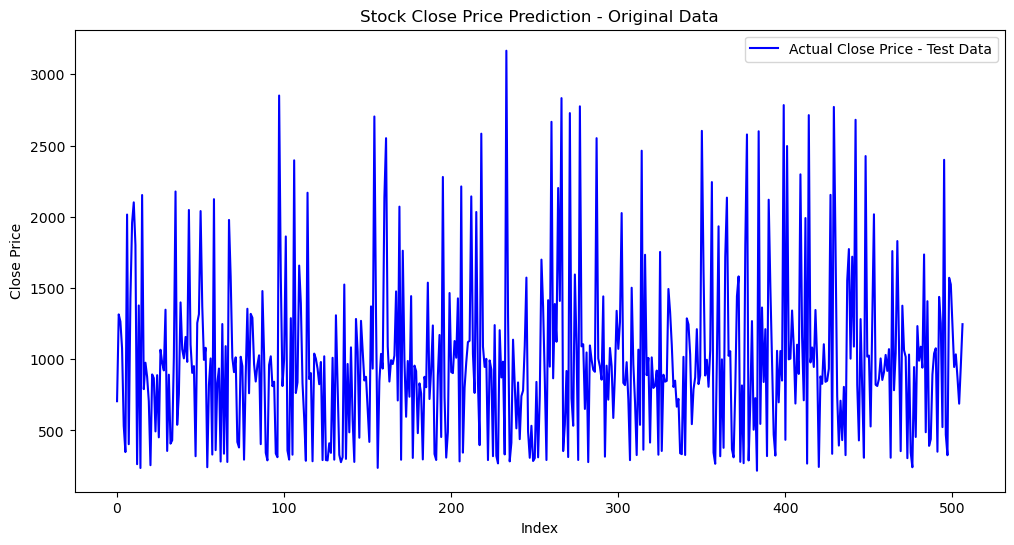

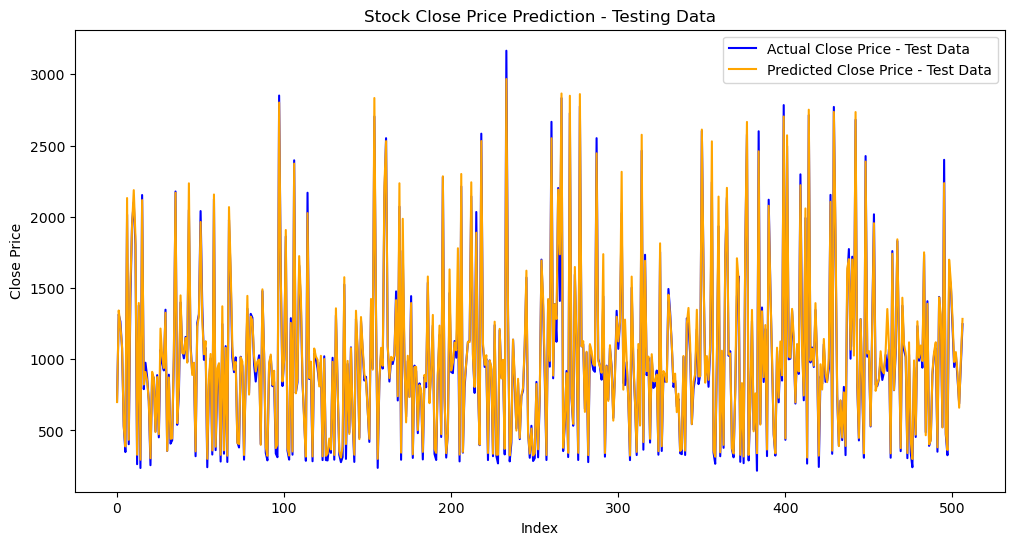

In [54]:
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
y_train_original = scaler_y.inverse_transform(y_train)
y_test_original = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(range(len(y_test_original)), y_test_original, color='blue', label='Actual Close Price - Test Data')
plt.title('Stock Close Price Prediction - Original Data')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

# Plot testing data
plt.plot(range(len(y_test_original)), y_test_original, color='blue', label='Actual Close Price - Test Data')
plt.plot(range(len(test_predict)), test_predict, color='orange', label='Predicted Close Price - Test Data')

plt.title('Stock Close Price Prediction - Testing Data')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [55]:
df3 = pd.read_csv("TCS.csv")
df3.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-08-25,TCS,EQ,850.00,1198.7,1198.7,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
1,2004-08-26,TCS,EQ,987.95,992.0,997.0,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2,2004-08-27,TCS,EQ,979.00,982.4,982.4,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
3,2004-08-30,TCS,EQ,962.65,969.9,990.0,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
4,2004-08-31,TCS,EQ,986.75,986.5,990.0,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624


In [56]:
print(df3.isnull().sum())

Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                1683
Deliverable Volume       0
%Deliverble              0
dtype: int64


In [57]:
print(df3.columns)

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')


In [58]:
X = df3[['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Volume','Turnover']].values
y = df3['Close'].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

seq_len = 7
X_lstm = []
y_lstm = []

for i in range(seq_len, len(X_scaled)):
    X_lstm.append(X_scaled[i-seq_len:i])
    y_lstm.append(y_scaled[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

In [59]:
#RELIANCE split dataset 50-40-10(Only cause the dataset is too big)
X_train, X_, y_train, y_ = train_test_split(X_lstm,y_lstm,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.2, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (2015, 7, 8) X_cv.shape: (1612, 7, 8) X_test.shape: (403, 7, 8)


In [60]:
#Predict using trained LSTM model
test_predict = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [61]:
test_mae = mean_absolute_error(y_test, test_predict)
print(f"Testing MAE: {test_mae:.4f}")

Testing MAE: 0.0759


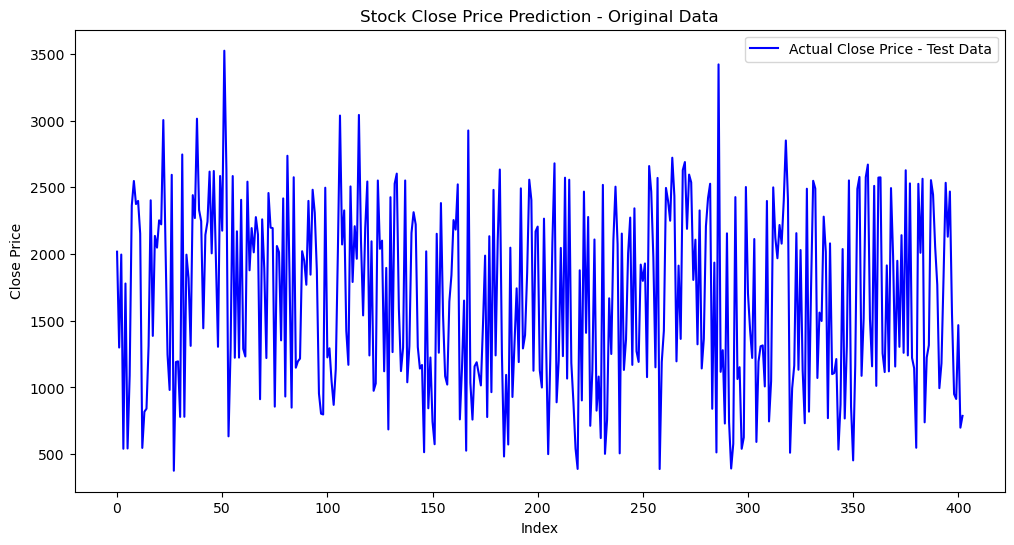

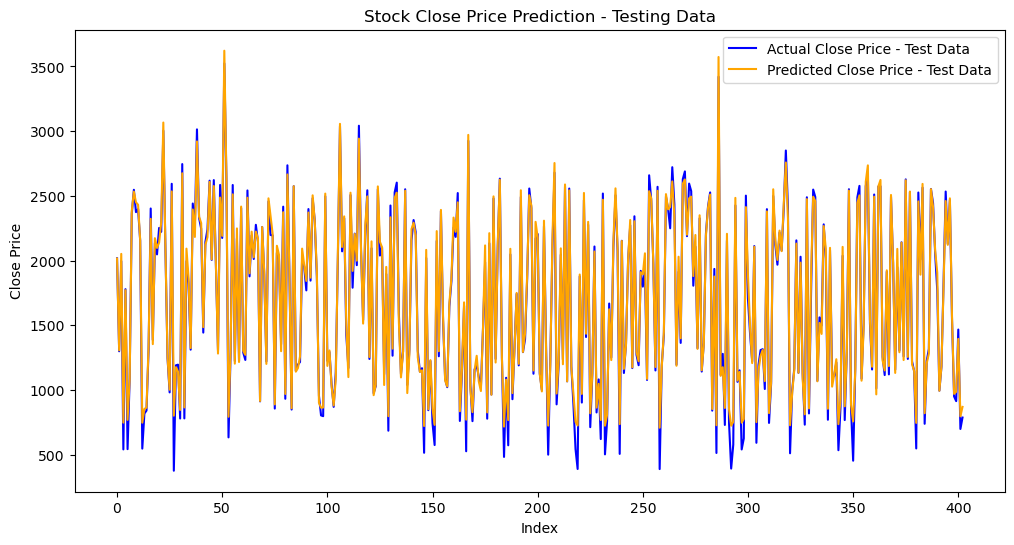

In [62]:
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
y_train_original = scaler_y.inverse_transform(y_train)
y_test_original = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(range(len(y_test_original)), y_test_original, color='blue', label='Actual Close Price - Test Data')
plt.title('Stock Close Price Prediction - Original Data')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

# Plot testing data
plt.plot(range(len(y_test_original)), y_test_original, color='blue', label='Actual Close Price - Test Data')
plt.plot(range(len(test_predict)), test_predict, color='orange', label='Predicted Close Price - Test Data')

plt.title('Stock Close Price Prediction - Testing Data')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()